# TensorFlow2教程-自定义训练实战

本教程我们将使用TensorFlow来实现鸢尾花分类。整个过程包括：构建模型、模型训练、模型预测。



## 导入相关库
导入TensorFlow和其他所需的Python模块。 默认情况下，TensorFlow2使用急切执行来程序，会立即返回结果。


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt

In [2]:
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

     |████████████████████████████████| 79.9MB 429kB/s 
     |████████████████████████████████| 3.0MB 34.9MB/s 
     |████████████████████████████████| 419kB 55.7MB/s 


In [5]:
print('tf version:', tf.__version__)
print('eager execution:', tf.executing_eagerly())

tf version: 2.0.0-alpha0
eager execution: True


In [9]:
!nvidia-smi

Fri Aug  2 13:34:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 鸢尾花分类问题

想象一下，你是一名植物学家，正在寻找一种自动化的方法来对你找到的每种鸢尾花进行分类。 机器学习提供了许多算法来对花进行统计分类。 例如，复杂的机器学习程序可以基于照片对花进行分类。而这里，我们将根据萼片和花瓣的长度和宽度测量来对鸢尾花进行分类。

鸢尾花有300多种类别，但我们的这里主要对以下三种进行分类：
- Iris setosa
- Iris virginica
- Iris versicolor
# ![](https://www.tensorflow.org/images/iris_three_species.jpg)

幸运的是，有人已经用萼片和花瓣测量创建了120个鸢尾花的数据集。 这是一个流行的初学者机器学习分类问题的经典数据集。

下载数据集
使用tf.keras.utils.get_file函数下载训练数据集文件。 这将返回下载文件的文件路径。

In [0]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)
print('下载数据至：', train_dataset_fp)

下载数据至： /root/.keras/datasets/iris_training.csv


## 检查数据
此数据集iris_training.csv是一个纯文本文件，用于存储格式为逗号分隔值（CSV）的表格数据。 使用head -n5命令在前五个条目中取一个峰值：

In [0]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


从数据集的此视图中，请注意以下内容：

第一行是包含有关数据集的信息的标题：
总共有120个例子。 每个示例都有四个特征和三个可能的标签名称之一。
后续行是数据记录，每行一个示例，其中：
前四个字段是特征：这些是示例的特征。 这里，字段包含代表花卉测量值的浮点数。
最后一列是标签：这是我们想要预测的值。 对于此数据集，它是与花名称对应的整数值0,1或2。


In [0]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
# 获取特征和标签名
feature_name = column_names[:-1]
label_name = column_names[-1]

每个标签都与字符串名称相关联（例如，“setosa”），但机器学习通常依赖于数值。使用标签数字来映射类别，例如：

- 0：Iris setosa:
- 1：Iris versicolor
- 2：Iris virginica


In [0]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

## 创建一个 tf.data.Dataset
TensorFlow的数据集API处理许多将数据加载到模型中的常见情况。这是一个高级API，用于读取数据并将其转换为用于训练的数据类型。

由于数据集是CSV格式的文本文件，因此需要使用make_csv_dataset函数将数据解析为合适的格式。由于此函数为训练模型生成数据，因此默认行为是对数据（shuffle=True, shuffle_buffer_size=10000）进行混洗，并永远重复数据集（num_epochs=None）。同时还需要设置batch_size参数。

In [0]:
batch_size=32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

该make_csv_dataset函数返回tf.data.Dataset的(features, label)对，其中features是一个字典：{'feature_name': value}

而这些Dataset对象是可迭代的。

In [0]:
features, labels = next(iter(train_dataset))
print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=64, shape=(32,), dtype=float32, numpy=
array([7.6, 6.9, 7.2, 5. , 6.7, 4.8, 5.4, 5.1, 7.7, 6. , 6.3, 7.4, 5.2,
       7.2, 6.7, 6.1, 5. , 4.9, 6.2, 4.5, 6.6, 6. , 5.5, 6.3, 4.8, 6.7,
       6.1, 5.6, 7.3, 6.9, 5.7, 6.3], dtype=float32)>), ('sepal_width', <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
array([3. , 3.2, 3.6, 2.3, 3. , 3. , 3.9, 3.7, 3. , 2.2, 2.3, 2.8, 2.7,
       3.2, 3.1, 2.8, 3.4, 3.1, 2.8, 2.3, 3. , 3. , 3.5, 3.3, 3.4, 3. ,
       2.8, 2.9, 2.9, 3.1, 3.8, 2.5], dtype=float32)>), ('petal_length', <tf.Tensor: id=62, shape=(32,), dtype=float32, numpy=
array([6.6, 5.7, 6.1, 3.3, 5.2, 1.4, 1.3, 1.5, 6.1, 5. , 4.4, 6.1, 3.9,
       6. , 5.6, 4. , 1.6, 1.5, 4.8, 1.3, 4.4, 4.8, 1.3, 6. , 1.6, 5. ,
       4.7, 3.6, 6.3, 4.9, 1.7, 5. ], dtype=float32)>), ('petal_width', <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
array([2.1, 2.3, 2.5, 1. , 2.3, 0.3, 0.4, 0.4, 2.3, 1.5, 1.3, 1.9, 1.4,
       1.8, 2.4, 1.3, 0.4, 0.1, 1

相同的特征被放在同一个数组中，数组维度为batch_size大小。
可以可视化如图：

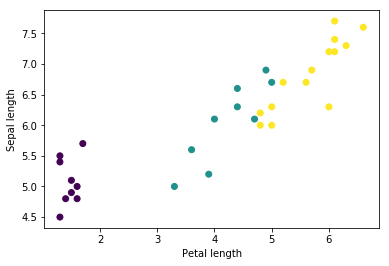

In [0]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

一般我们会把同一个数据的不同feature放在同一个数组中，我们使用tf.pack()來将features重构为(batch_size, num_features)形状。

In [0]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [0]:
# 使用tf.data.Dataset.map将重构函数运用到每条数据中。
train_dataset = train_dataset.map(pack_features_vector)
# 查看前5个数据
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[7.6 3.  6.6 2.1]
 [6.9 3.2 5.7 2.3]
 [7.2 3.6 6.1 2.5]
 [5.  2.3 3.3 1. ]
 [6.7 3.  5.2 2.3]], shape=(5, 4), dtype=float32)


## 选择模型

一个模型是功能和标签之间的关系。对于鸢尾花分类问题，该模型定义了萼片和花瓣测量与预测的鸢尾花物种之间的关系。一些简单的模型可以用几行代数来描述，但是复杂的机器学习模型具有很多难以概括的参数。

我们能否在不使用机器学习的情况下确定四种特征与虹膜物种之间的关系？也就是说，可以使用传统的编程技术（例如，很多条件语句）来创建模型吗？也许 - 如果你对数据集进行了足够长的分析，以确定特定物种的花瓣和萼片测量值之间的关系。这对于更复杂的数据集来说变得困难 - 可能是不可能的。良好的机器学习方法可以为我们确定模型。如果我们将足够的代表性示例提供给正确的机器学习模型类型，程序将为我们找出关系。

选择具体模型

我们需要选择要训练的模型。有很多类型的模型和挑选一个好的经验。本教程使用神经网络来解决鸢尾花I分类问题。神经网络可以找到特征和标签之间的复杂关系。它是一个高度结构化的图，组织成一个或多个隐藏层。每个隐藏层由一个或多个神经元组成。有几类神经网络，这个程序使用密集或完全连接的神经网络：一层中的神经元接收来自每个神经网络的输入连接上一层的神经元。例如，图2说明了一个由输入层，两个隐藏层和一个输出层组成的密集神经网络：

![](https://www.tensorflow.org/images/custom_estimators/full_network.png)
图2.具有特征，隐藏层和预测的神经网络。
 
当对来自图2的模型进行训练并喂入未标记的示例时，它产生三个预测：该花是给定的鸢尾花物种的可能性。这种预测称为推理。对于此示例，输出预测的总和为1.0。在图2中，该预测分解为：0.02对山鸢尾，0.95对于变色鸢尾，并0.03为锦葵鸢尾。这意味着模型以95％的概率预测 - 未标记的示例花是变色鸢尾。

##使用Keras创建模型

TensorFlow tf.keras API是创建模型和图层的首选方式。这使得构建模型和实验变得容易，而Keras处理将所有内容连接在一起的复杂性。

该tf.keras.Sequential模型是层的线性堆栈。它的构造函数采用一个层实例列表，在这种情况下，两个Dense层各有10个节点，一个输出层有3个节点代表我们的标签预测。第一层的input_shape参数对应于数据集中的要素数，并且是必需的。

In [0]:
# 构建线性模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu',input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

激活函数确定在层中的每个节点的输出形状。这些非线性很重要 - 没有它们，模型将等同于单个层。有许多可用的激活，但ReLU对于隐藏层是常见的。

隐藏层和神经元的理想数量取决于问题和数据集。像机器学习的许多方面一样，选择神经网络的最佳形状需要知识和实验经验。根据经验，增加隐藏层和神经元的数量通常会创建一个更强大的模型，这需要更多的数据来有效地训练。

## 测试模型结构

In [0]:
prediction = model(features)
prediction[:5]

<tf.Tensor: id=229, shape=(5, 3), dtype=float32, numpy=
array([[1.6543204 , 0.12405288, 0.24490094],
       [1.4488522 , 0.11291474, 0.24872684],
       [1.5161525 , 0.11867774, 0.28899187],
       [0.86002606, 0.05858952, 0.06260413],
       [1.3767202 , 0.10884094, 0.21688706]], dtype=float32)>

多分类任务需要使用softmax进行归一化

In [0]:
tf.nn.softmax(prediction)[:5]

<tf.Tensor: id=235, shape=(5, 3), dtype=float32, numpy=
array([[0.6845738 , 0.148195  , 0.16723117],
       [0.63935834, 0.16809471, 0.19254689],
       [0.6492055 , 0.16049689, 0.1902975 ],
       [0.52654505, 0.23625231, 0.23720267],
       [0.62697244, 0.1764475 , 0.19658   ]], dtype=float32)>

使用tf.argmax获取概率最大的类标签

In [0]:
print('prediction:', tf.argmax(prediction, axis=1))
print('label:', labels)

prediction: tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)
label: tf.Tensor([2 2 2 1 2 0 0 0 2 2 1 2 1 2 2 1 0 0 2 0 1 2 0 2 0 1 1 1 2 1 0 2], shape=(32,), dtype=int32)


# 训练模型
训练是机器学习中模型从数据集中学习知识并优化自身能力的过程。

Iris分类问题是一个典型的监督学习问题，其通过包含标签的数据集进行学习。而无监督学习则是仅从特征中去寻找相应的模式。

训练和评估的过程都需要计算模型的损失，它可以衡量预测与正确标签的差距，训练过程都是要最小化损失。

我们后面将直接使用tf.keras里面包装好的损失函数来计算损失。



In [0]:
# 损失函数
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [0]:
# 获取损失
def loss(model, x, y):
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_)
l = loss(model, features, labels)
print(l)

tf.Tensor(1.3738844, shape=(), dtype=float32)


使用tf.GradientTape计算loss对所有变量的梯度。


In [0]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## 创建优化器

优化程序将计算出的梯度应用于模型的变量，以最大限度地减少损失函数。 您可以将损失函数视为曲面（参见图3），我们希望通过四处走动找到它的最低点。 渐变指向最陡的上升方向 - 所以我们将以相反的方向行进并向下移动。 通过迭代计算每批的损失和梯度，我们将在训练期间调整模型。 逐渐地，该模型将找到权重和偏差的最佳组合，以最小化损失。 损失越低，模型的预测越好。

![](https://cs231n.github.io/assets/nn3/opt1.gif)

TensorFlow有许多可用于训练的优化算法。 该模型使用tf.train.GradientDescentOptimizer实现随机梯度下降（SGD）算法。 learning_rate设置每次迭代下一步的步长。 这是一个超参数，您通常会调整以获得更好的结果。

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

优化器使用如下

In [0]:
loss_value, grads = grad(model, features, labels)
print('步数：{}, 初始loss值：{}'.format(optimizer.iterations.numpy(),
                                loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print('步数：{}, loss值：{}'.format(optimizer.iterations.numpy(),
                                loss(model,features, labels).numpy()))

步数：0, 初始loss值：1.3738844394683838
步数：1, loss值：1.1648454666137695


## 训练循环
每个epoch数据将会被训练一次。

In [0]:
# 保存loss和acc
train_loss_results=[]
train_accuracy_results=[]

num_epochs =201
for epoch in range(num_epochs):
    # 用于记录loss和acc的类
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # 训练循环
    for x, y in train_dataset:
        # 获取loss和梯度
        loss_value, grads = grad(model, x, y)
        # 梯度优化
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # 记录loss均值
        epoch_loss_avg(loss_value)
        # 记录准确率
        epoch_accuracy(y, model(x))

    # 保存每个epoch的loss和acc
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))


Epoch 000: Loss: 1.048, Accuracy: 70.000%
Epoch 050: Loss: 0.074, Accuracy: 99.167%
Epoch 100: Loss: 0.059, Accuracy: 99.167%
Epoch 150: Loss: 0.054, Accuracy: 99.167%
Epoch 200: Loss: 0.051, Accuracy: 99.167%


## 可视化训练过程


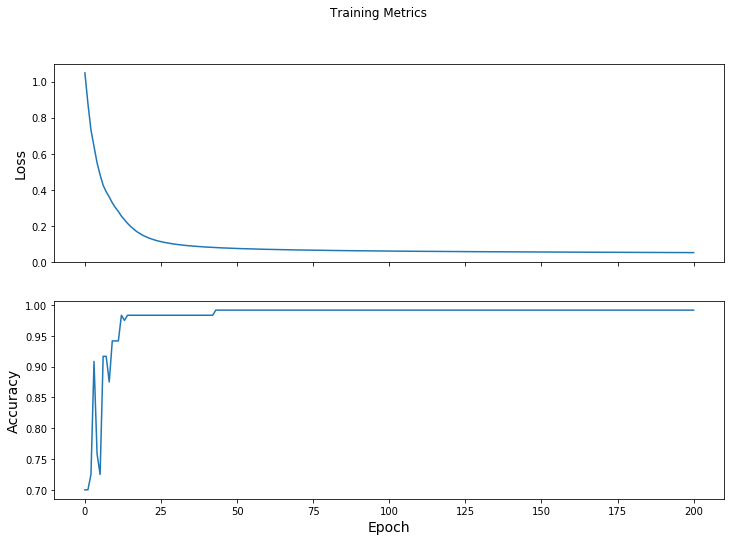

In [0]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 评估模型
评估模型类似于训练模型。 最大的区别是示例来自单独的测试集而不是训练集。 为了公平地评估模型的有效性，用于评估模型的示例必须与用于训练模型的示例不同。

测试数据集的设置类似于训练数据集的设置。 下载CSV文本文件并解析该值，然后将其打乱：

In [0]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

评估测试数据集上的模型

与训练阶段不同，该模型仅评估测试数据的单个时期。 在下面的代码单元格中，我们迭代测试集中的每个示例，并将模型的预测与实际标签进行比较。 这用于测量整个测试集中模型的准确性。

In [0]:
# 准确率统计类
test_accuracy = tf.keras.metrics.Accuracy()

for (x,y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y) 

print('测试集准确率：', test_accuracy.result())

测试集准确率： tf.Tensor(0.96666664, shape=(), dtype=float32)


结果对比


In [0]:
tf.stack([y, prediction], axis=1)

<tf.Tensor: id=164737, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

##使用训练的模型进行预测

我们已经训练了一个模型并且“证明”它对Iris物种进行分类是好的 - 但不是完美的。 现在让我们使用训练有素的模型对未标记的例子做出一些预测; 也就是说，包含特征但不包含标签的示例。

在现实生活中，未标记的示例可能来自许多不同的来源，包括应用程序，CSV文件和数据源。 目前，我们将手动提供三个未标记的示例来预测其标签。 回想一下，标签号被映射到命名表示，如下所示：
- 0: Iris setosa
- 1: Iris versicolor
- 2: Iris virginica

In [0]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.9%)
Example 1 prediction: Iris versicolor (99.9%)
Example 2 prediction: Iris virginica (99.1%)
